In [2]:
from sliding_window_dataset import SlidingWindowDataset
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv('all_merged_data.csv', parse_dates=['datetime'])

# Extract datetime features
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['dayofweek'] = df['datetime'].dt.dayofweek

# Move new columns right after the index column (assumed to be the first column)
cols = list(df.columns)
# Remove the datetime and new columns from their current positions
cols.remove('datetime')
for col in ['trip_number', 'year', 'month', 'day', 'dayofweek']:
    cols.remove(col)
# Insert new columns after the index column (position 1)
for i, col in enumerate(['trip_number', 'year', 'month', 'day', 'dayofweek']):
    cols.insert(1 + i, col)
# Drop datetime and reorder colaumns
df = df[cols]
df = df.set_index(['trip_number', df.index])

df.head()

RPM  year  month  day  dayofweek  THR  Fdet  Speed  Twat  \
trip_number                                                                 
1           0  753.5  2024     12   16          0  3.0   0.0    0.0  97.5   
            1  751.0  2024     12   16          0  3.0   0.0    0.0  97.5   
            2  754.0  2024     12   16          0  3.0   0.0    0.0  97.5   
            3  751.0  2024     12   16          0  3.0   0.0    0.0  97.5   
            4  751.0  2024     12   16          0  3.0   0.0    0.0  97.5   

                INJ  ...  COEFF  Tair  Fxx   Ubat  TPS  Gear  oil_press    vp  \
trip_number          ...                                                        
1           0  2.90  ...   1.02  35.3  1.0  14.00  0.0   0.0       0.26  1.49   
            1  2.86  ...   0.99  35.3  1.0  14.10  0.0   0.0       0.26  1.47   
            2  2.89  ...   1.01  35.3  1.0  14.05  0.0   0.0       0.26  1.49   
            3  2.83  ...   0.98  35.3  1.0  14.00  0.0   0.0       0.25  1.46   
            4  2.89  ...   1.01  35.3  1.0  14.00  0.0   0.0       0.26  1.47   

               oil_temp    vt  
trip_number                    
1           0     108.6  1.47  
            1     108.6  1.47  
            2     108.6  1.47  
            3     108.6  1.47  
            4     108.6  1.47  

[5 rows x 25 columns]

In [4]:
df = df.iloc[:, :-4]  # Drop the first index column
df.columns

Index(['RPM', 'year', 'month', 'day', 'dayofweek', 'THR', 'Fdet', 'Speed',
       'Twat', 'INJ', 'AIR', 'GBC', 'ADC_LAM', 'UOZ', 'Press', 'COEFF', 'Tair',
       'Fxx', 'Ubat', 'TPS', 'Gear'],
      dtype='object')

In [5]:
df = df.dropna()
dataset = SlidingWindowDataset(df, target=None, window_size=60, stride=60)
print(len(dataset))
print(dataset[0])

Building safe windows: 100%|██████████| 187/187 [00:00<00:00, 1258.13it/s]

7818
(tensor([[ 753.5000, 2024.0000,   12.0000,  ...,   14.0000,    0.0000,
            0.0000],
        [ 751.0000, 2024.0000,   12.0000,  ...,   14.1000,    0.0000,
            0.0000],
        [ 754.0000, 2024.0000,   12.0000,  ...,   14.0500,    0.0000,
            0.0000],
        ...,
        [ 918.0000, 2024.0000,   12.0000,  ...,   14.1000,    0.0000,
            0.0000],
        [ 819.0000, 2024.0000,   12.0000,  ...,   14.0000,    0.0000,
            0.0000],
        [ 795.0000, 2024.0000,   12.0000,  ...,   14.0500,    0.0000,
            0.0000]]), tensor([7.9500e+02, 2.0240e+03, 1.2000e+01, 1.6000e+01, 0.0000e+00, 4.0000e+00,
        0.0000e+00, 5.0000e+00, 9.9000e+01, 3.4100e+00, 1.4550e+01, 1.5260e+02,
        1.5000e-01, 5.3000e+00, 4.3775e+02, 1.0500e+00, 3.6800e+01, 1.0000e+00,
        1.4050e+01, 0.0000e+00, 0.0000e+00]))


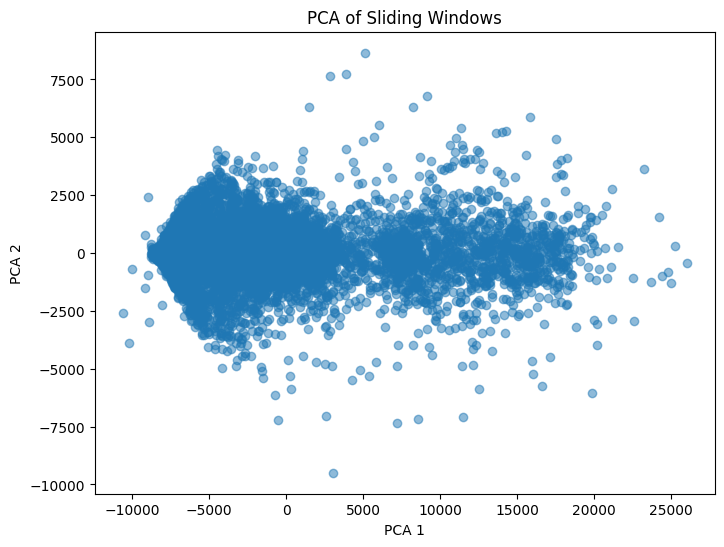

In [23]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Собираем все окна в массив
X = np.stack([window.numpy().flatten() for window, _ in dataset])

# PCA до 2 компонент
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Визуализация
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], alpha=0.5)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('PCA of Sliding Windows')
plt.show()

In [24]:
from torch.utils.data import DataLoader

loader = DataLoader(dataset, batch_size=128, shuffle=True)

In [25]:
import torch.nn as nn

class MLPAutoencoder(nn.Module):
    def __init__(self, input_dim, bottleneck_dim=40):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, bottleneck_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_dim, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out

In [27]:
import torch
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_dim = dataset[0][0].numel()
model = MLPAutoencoder(input_dim=input_dim, bottleneck_dim=40).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

for epoch in range(100):  # увеличьте число эпох по необходимости
    model.train()
    total_loss = 0
    for batch, _ in loader:
        batch = batch.view(batch.size(0), -1).to(device)
        optimizer.zero_grad()
        output = model(batch)
        loss = criterion(output, batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch.size(0)
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(dataset):.6f}")

Epoch 1, Loss: 96913.149091
Epoch 2, Loss: 17816.483713
Epoch 3, Loss: 7282.775178
Epoch 4, Loss: 7174.827232
Epoch 5, Loss: 7161.432050
Epoch 6, Loss: 7129.880902
Epoch 7, Loss: 7114.363302
Epoch 8, Loss: 7045.909989
Epoch 9, Loss: 6920.139019
Epoch 10, Loss: 6523.545325
Epoch 11, Loss: 6014.184330
Epoch 12, Loss: 5841.715810
Epoch 13, Loss: 5678.752341
Epoch 14, Loss: 5453.562440
Epoch 15, Loss: 5276.809273
Epoch 16, Loss: 5163.314887
Epoch 17, Loss: 4999.127388
Epoch 18, Loss: 4835.230964
Epoch 19, Loss: 4725.247526
Epoch 20, Loss: 4625.539928
Epoch 21, Loss: 4555.462744
Epoch 22, Loss: 4499.899637
Epoch 23, Loss: 4423.460110
Epoch 24, Loss: 4347.697982
Epoch 25, Loss: 4263.671471
Epoch 26, Loss: 4191.453767
Epoch 27, Loss: 4127.334609
Epoch 28, Loss: 4082.022250
Epoch 29, Loss: 3968.298379
Epoch 30, Loss: 3870.476813
Epoch 31, Loss: 3786.756000
Epoch 32, Loss: 3720.421033
Epoch 33, Loss: 3645.137254
Epoch 34, Loss: 3600.146999
Epoch 35, Loss: 3524.617004
Epoch 36, Loss: 3465.028086

In [28]:
# 1. Создаём датасет с stride=60 (как для PCA)
dataset_stride60 = SlidingWindowDataset(df, target=None, window_size=60, stride=60)
loader_stride60 = DataLoader(dataset_stride60, batch_size=128, shuffle=False)

# 2. Получаем bottleneck-вектора из энкодера
model.eval()
all_bottlenecks = []

with torch.no_grad():
    for batch, _ in loader_stride60:
        batch = batch.view(batch.size(0), -1).to(device)
        bottleneck = model.encoder(batch)  # shape: [batch_size, 40]
        all_bottlenecks.append(bottleneck.cpu().numpy())

# 3. Собираем всё в один массив
all_bottlenecks = np.concatenate(all_bottlenecks, axis=0)  # shape: [num_windows, 40]

# 4. Сохраняем вектора, например, в .npy или .csv
np.save('bottleneck_vectors.npy', all_bottlenecks)
# или
np.savetxt('bottleneck_vectors.csv', all_bottlenecks, delimiter=',')

print("Bottleneck vectors shape:", all_bottlenecks.shape)

Building safe windows:   0%|          | 0/187 [00:00<?, ?it/s]

Building safe windows: 100%|██████████| 187/187 [00:00<00:00, 803.17it/s]


Bottleneck vectors shape: (7818, 40)


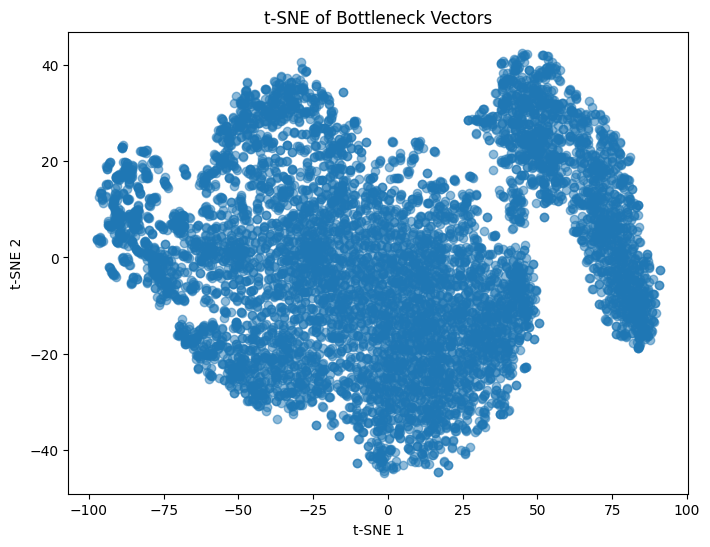

In [29]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# all_bottlenecks — это массив shape [num_windows, 40]
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(all_bottlenecks)

plt.figure(figsize=(8,6))
plt.scatter(X_tsne[:,0], X_tsne[:,1], alpha=0.5)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE of Bottleneck Vectors')
plt.show()